In [1]:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import IFrame, Image
from entur_collector.dataanalysis.deviationssampler import refine_deviations

In [2]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
plotly_interactive = False
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))

In [3]:
df = refine_deviations()

In [5]:
df.tail()

,aimed_arrival,timestamp,expected_arrival,expected_delay,day_of_week,time_of_day,month,day_number,day_since_start
1067,2025-10-29 06:34:00+01:00,2025-10-29 05:35:51+01:00,2025-10-29 06:38:22+01:00,0 days 00:04:22,2,06:34:00,10,332,331
1068,2025-10-29 07:04:00+01:00,2025-10-29 06:19:16+01:00,2025-10-29 07:21:32+01:00,0 days 00:17:32,2,07:04:00,10,332,331
1069,2025-10-29 07:34:00+01:00,2025-10-29 06:40:12+01:00,2025-10-29 07:43:04+01:00,0 days 00:09:04,2,07:34:00,10,332,331
1070,2025-10-29 08:04:00+01:00,2025-10-29 07:22:46+01:00,2025-10-29 08:25:58+01:00,0 days 00:21:58,2,08:04:00,10,332,331
1071,2025-10-29 08:34:00+01:00,2025-10-29 07:47:39+01:00,2025-10-29 08:51:35+01:00,0 days 00:17:35,2,08:34:00,10,332,331


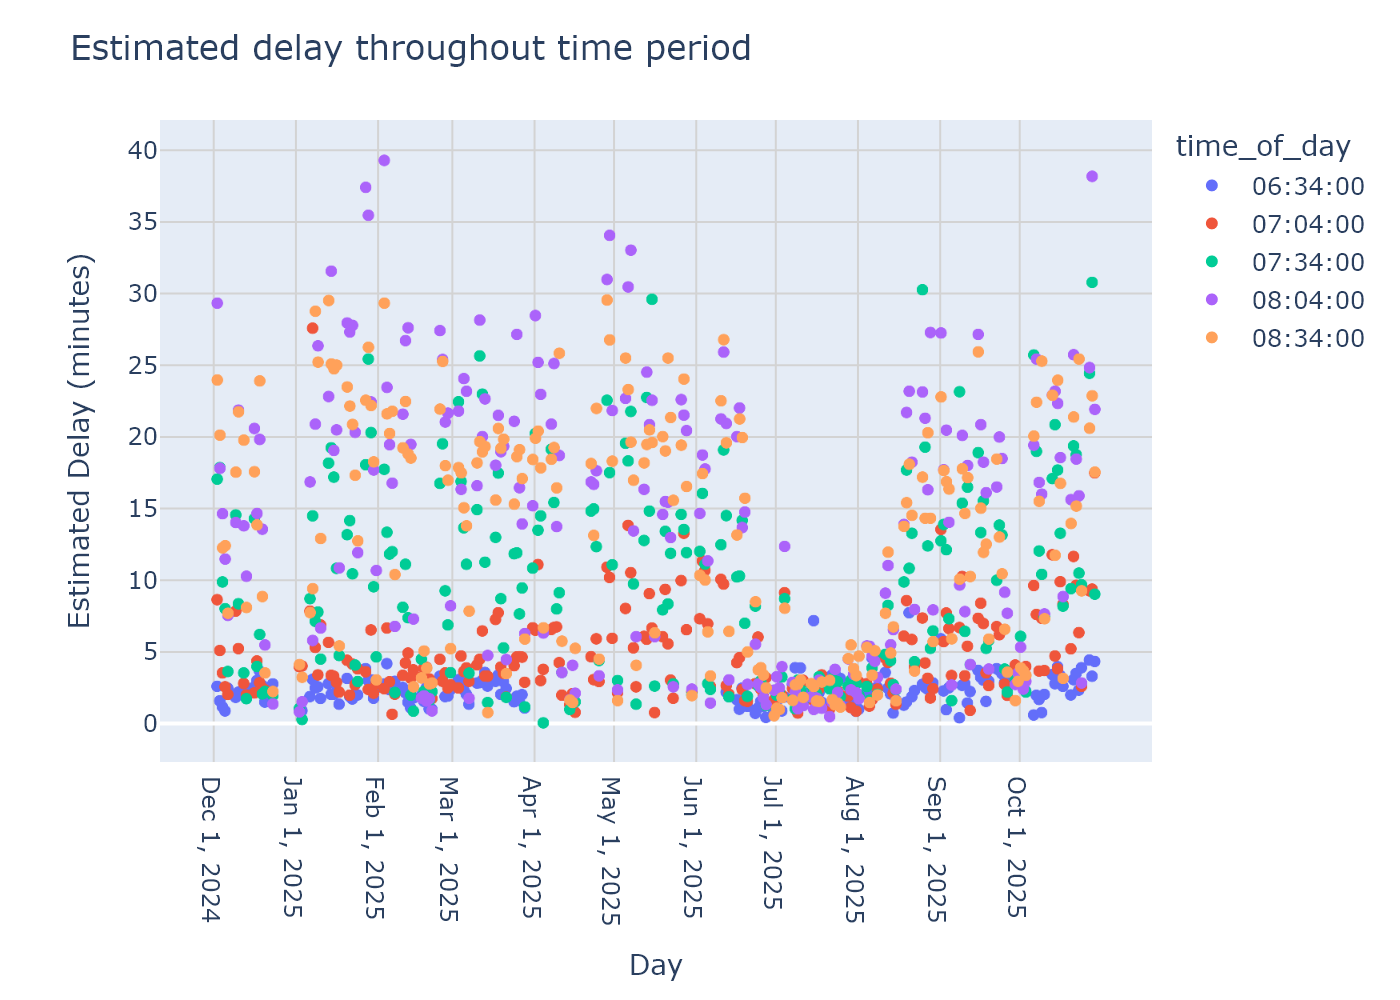

In [6]:
fig = px.scatter(df, x="aimed_arrival", y=df["expected_delay"].dt.total_seconds() / 60, color="time_of_day")
fig.layout.yaxis.title = "Estimated Delay (minutes)"
fig.layout.xaxis.title = "Day"
fig.layout.title = "Estimated delay throughout time period"

fig.layout.yaxis.showgrid = True
fig.layout.yaxis.gridwidth = 1
fig.layout.yaxis.gridcolor = 'lightgray'

fig.layout.xaxis.showgrid = True
fig.layout.xaxis.gridwidth = 1
fig.layout.xaxis.gridcolor = 'lightgray'
fig.layout.xaxis.tickvals = [f"2025-{i:02d}-01" for i in range(1,11)] + ["2024-12-01"]

show_figure(fig)

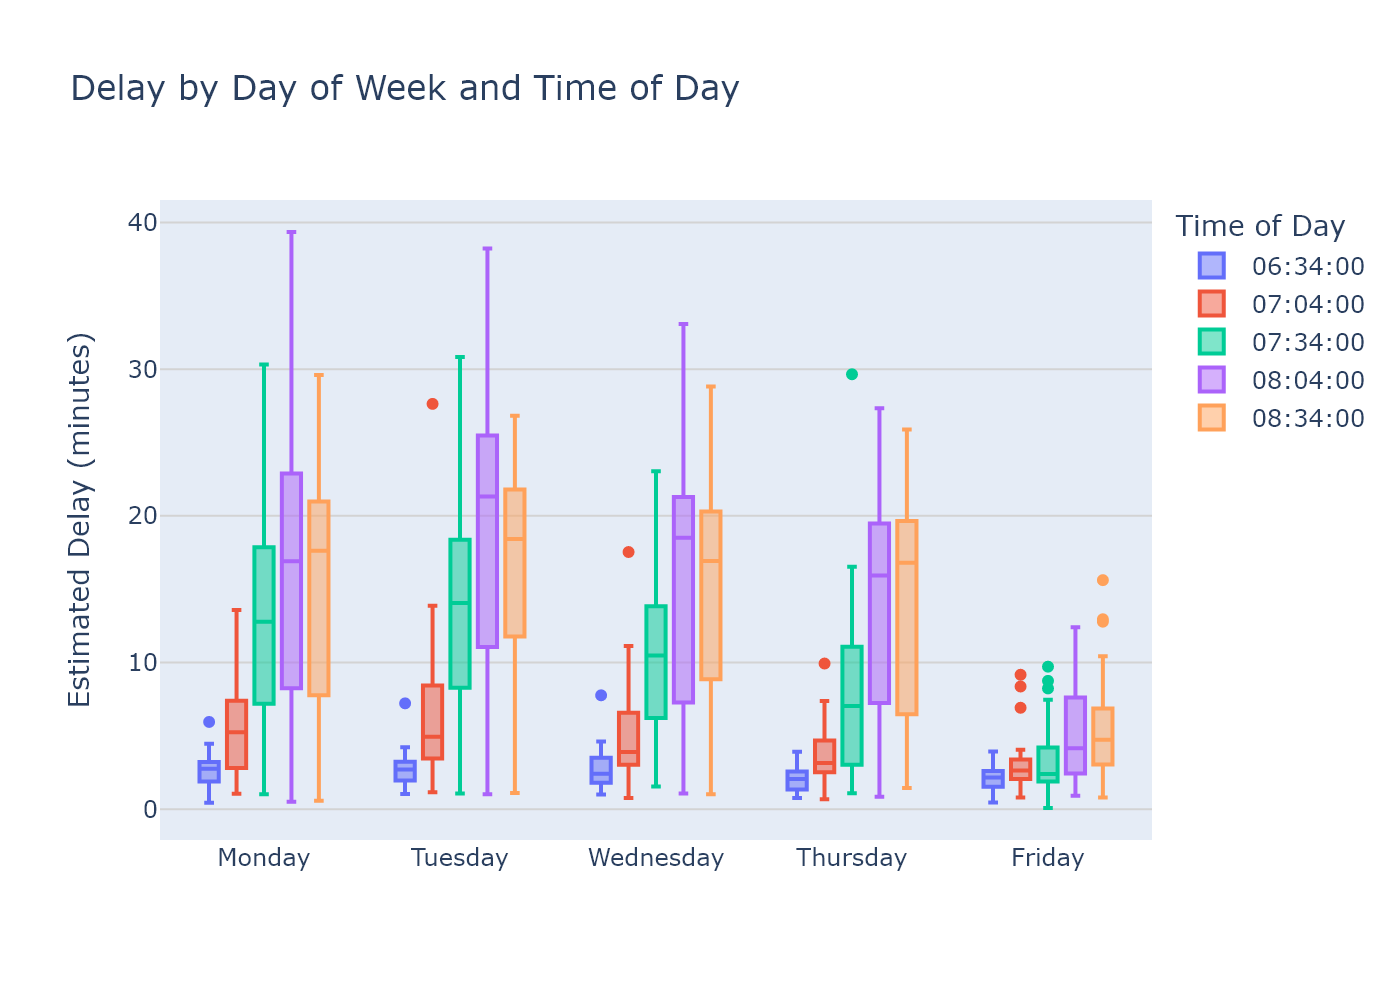

In [7]:
df.groupby(["day_of_week", "time_of_day"])

mean_delays = df.groupby(["day_of_week", "time_of_day"])["expected_delay"].mean().dt.total_seconds() / 60
# std_delays = df.groupby(["day_of_week", "time_of_day"])["expected_delay"].std().dt.total_seconds() / 60
mean_delays = mean_delays.reset_index()


fig = px.box(
    df,
    x="day_of_week",
    y=df["expected_delay"].dt.total_seconds() / 60,
    # color=list(mean_delays["time_of_day"].values.astype(str)),
    color="time_of_day",
    labels={'day_of_week': 'Day of Week', 'time_of_day': 'Time of Day'},
    title='Delay by Day of Week and Time of Day',
)

fig.layout.yaxis.showgrid = True
fig.layout.yaxis.gridwidth = 1
fig.layout.yaxis.gridcolor = 'lightgray'
fig.layout.yaxis.title = "Estimated Delay (minutes)"

fig.layout.yaxis.dtick = 10
fig.layout.yaxis.zeroline = True
fig.layout.yaxis.zerolinewidth = 1
fig.layout.yaxis.zerolinecolor = 'lightgray'

fig.layout.xaxis.title = ""

day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig.update_xaxes(ticktext=day_labels, tickvals=[0, 1, 2, 3, 4])

show_figure(fig)